In [1]:
import sys
sys.path.append('/home/mourad/DS/Mosmovi/Mosmovi/')
import pandas as pd
import os
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import random

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 100)
from collections import Counter

import unicodedata
import importlib

from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', lambda x: '%.18f' % x)

In [2]:
def format_csvs_to_df(path):
    file_names = os.listdir(path)
    frames = []
    for n in file_names:
        coordinates = [float(x) for x in n[:-4].split('_')]
        df = pd.read_csv(path + n, sep=';')
        df['coordinates'] = [coordinates] * len(df)
        frames.append(df)
    df_total = pd.concat(frames)
    return df_total

def train_test_split_by_users(df, percentage_users = 0.10):
    """
    Take a dataframe in input and return train and test sets. 
    """
    users_ids = df.author_id
    users_ids = set(df.author_id)
    n_samples = int(len(users_ids)*percentage_users)
    val_users = random.sample(users_ids, n_samples)
    ind = df.author_id.isin(val_users)
    return df.loc[~ind], df.loc[ind]

In [ ]:
%%time
df = format_csvs_to_df('../../data/Copy of dev_south_america_merged/')
df['id'] = df['id'].astype(int).astype(str)
# df = pd.read_csv('../data/formated.csv')
print(df.shape)

#### Split by users

In [76]:
train, test = train_test_split_by_users(df)

In [79]:
train.shape[0]/df.shape[0], test.shape[0]/df.shape[0], train.shape[0]/df.shape[0]+ test.shape[0]/df.shape[0]

(0.8967023982826929, 0.1032976017173071, 1.0)

## Number of tweets by user

In [151]:
df_gb = df.groupby(by='author_id').count().sort_values('id', ascending=False)[['id']].rename(columns={'id':'count'})

In [152]:
df_gb_toplot = df_gb.sort_values('count', ascending=False)#.reset_index()[['count']]
# df_gb_toplot = df_gb_toplot.loc[df_gb_toplot['count'] > 1]
df_gb_toplot.sum()

count    10815072
dtype: int64

In [153]:
def make_group2(x):
    if x < 100:
        if x < 10:
            return '<10'
        elif x < 20:
            return '10-20'
        elif x < 30:
            return '20-30'
        elif x < 40:
            return '30-40'
        elif x < 50:
            return '40-50'
        elif x < 60:
            return '50-60'
        elif x < 70:
            return '60-70'
        elif x < 80:
            return '70-80'
        elif x < 90:
            return '80-90'
        else:
            return '90-100'
    else:
        return '>100'

def make_order(x):
    if x == '<10':
        return 'a'
    elif x == '10-20':
        return 'b'
    elif x == '20-30':
        return 'c'
    elif x == '30-40':
        return 'd'
    elif x == '40-50':
        return 'e'
    elif x == '50-60':
        return 'f'
    elif x == '60-70':
        return 'g'
    elif x == '70-80':
        return 'h'
    elif x == '80-90':
        return 'i'
    elif x == '90-100':
        return 'j'
    elif x == '>100':
        return 'k'

In [154]:
df_gb_toplot['cat'] = df_gb_toplot['count'].apply(lambda x : make_group2(x))

,count,cat
author_id,,
7.267962e+17,11045,>100
1.352116e+18,10977,>100
2.076736e+08,9431,>100
1.677442e+08,9419,>100
1.643609e+08,8813,>100


In [155]:
df_gb_toplot2 = pd.DataFrame(df_gb_toplot.value_counts('cat')).reset_index().rename(columns={'cat':'cat', 0:'count'})
df_gb_toplot2['order'] = df_gb_toplot2['cat'].apply(lambda x : make_order(x))
df_gb_toplot2 = df_gb_toplot2.sort_values('order')
df_gb_toplot2[['cat', 'count']].set_index('cat').sum()

<AxesSubplot:xlabel='cat'>

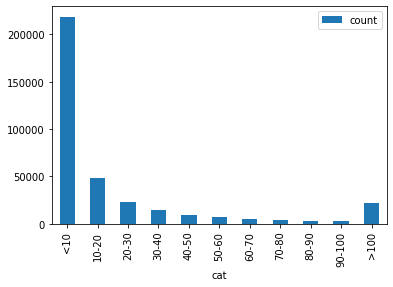

In [159]:
df_gb_toplot2[['cat', 'count']].set_index('cat').plot.bar()

### geo Distribution of the tweets

### Are the target in the bounding box? Answer: Yes

In [233]:
def box_calc(x):
    if isinstance(x, str):
        return [float(y) for y in x.replace('[', '').replace(']', '').split(',')]
    else:
        return None

def box_calc2(l):
    if isinstance(l, list):
        return (l[2] - l[0] ,l[3] - l[1])
    else:
        return None
    
def box_calc_surface(l):
    if isinstance(l, list):
        return ((l[2] - l[0])*(l[3] - l[1]))
    else:
        return None

def box_calc3(c,bb):
    if isinstance(bb, list):
        if isinstance(c, list):
            if c[0] < bb[3] and c[0] > bb[1]:
                if c[1] < bb[2] and c[0] > bb[0]:
                    return True
    else:
        return None

In [223]:
df['bbox'] = df.geo_geo_bbox.apply(lambda x : box_calc(x) )
df_box = df[['id', 'geo_place_id', 'bbox','author_id','coordinates']]
df_box['in_box'] = df_box.apply(lambda x : box_calc3(x['coordinates'],x['bbox']), axis = 1)
df_box['in_box'].value_counts()

<ipython-input-223-42f268abe832>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_box['in_box'] = df_box.apply(lambda x : box_calc3(x['coordinates'],x['bbox']), axis = 1)


True    4533274
Name: in_box, dtype: int64

### Size of bbox

In [231]:
df['bbox_size'] = df['bbox'].apply(lambda x : box_calc2(x))
df['bbox_size'].value_counts()

(0.4792360013276067, 1.0897030021182301)        931299
(0.7077421999999984, 0.3431966000000024)        518230
(0.4609870000000029, 0.6520220000000023)        497307
(0.752824000638995, 1.1014420003606298)         380277
(0.22488000262939067, 0.20964800382237936)      310253
                                                 ...  
(0.11866779999999721, 0.13531000000000049)           1
(0.010444599999999582, 0.009289700000000067)         1
(0.3089024000000009, 0.24415579999999792)            1
(0.009768999999998584, 0.014111500000000277)         1
(0.01026499999999686, 0.0214224999999999)            1
Name: bbox_size, Length: 8834, dtype: int64

#### Surface

In [234]:
df['bbox_surface'] = df['bbox'].apply(lambda x : box_calc_surface(x))

In [237]:
df['bbox_surface'].max()

1692.3569801441975

<AxesSubplot:>

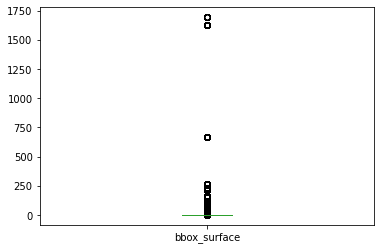

In [236]:
df['bbox_surface'].plot.box()

In [235]:
df['bbox_surface'].value_counts()

0.522225    931299
0.242895    518230
0.300574    497307
0.829192    380277
0.047146    310253
             ...  
0.016057         1
0.000097         1
0.075420         1
0.000138         1
0.000220         1
Name: bbox_surface, Length: 8834, dtype: int64

### Do users send tweets from the same location. 

In [206]:
Counter(df.groupby(by= 'id').geo_geo_bbox.nunique())

Counter({1: 6803910, 0: 486, 2: 1016})

In [209]:
df['coordinates_str'] = df.coordinates.apply(lambda x : str(x))

In [211]:
c_coo = Counter(df.groupby(by= 'id').coordinates_str.nunique())


In [217]:
c_coo_author = Counter(df.groupby(by= 'author_id').coordinates_str.nunique())
sorted(c_coo_author.items())

[(1, 193776),
 (2, 61045),
 (3, 34940),
 (4, 31871),
 (5, 12454),
 (6, 9166),
 (7, 6516),
 (8, 3140),
 (9, 1361),
 (10, 884),
 (11, 630),
 (12, 357),
 (13, 259),
 (14, 197),
 (15, 100),
 (16, 80),
 (17, 51),
 (18, 37),
 (19, 23),
 (20, 26),
 (21, 22),
 (22, 6),
 (23, 12),
 (24, 9),
 (25, 7),
 (26, 6),
 (27, 5),
 (28, 5),
 (29, 2),
 (30, 7),
 (31, 4),
 (32, 6),
 (33, 2),
 (34, 1),
 (35, 2),
 (37, 1),
 (38, 2),
 (39, 3),
 (40, 1),
 (41, 1),
 (42, 1),
 (44, 1),
 (47, 1),
 (49, 1),
 (52, 1),
 (54, 2),
 (55, 1),
 (60, 1),
 (63, 1),
 (67, 1),
 (72, 1),
 (79, 1),
 (81, 1),
 (83, 1),
 (86, 2),
 (93, 2),
 (95, 1),
 (96, 1),
 (136, 1),
 (174, 1),
 (193, 1),
 (205, 1)]

In [228]:
s = 0
for c in c_coo:
    s += c_coo_author[c]
s

355783

In [229]:
193776/355783

0.5446465963803779

In [215]:
s = 0
for c in c_coo:
    s += c_coo[c]
s

6805412

In [212]:
sorted(c_coo.items())

[(1, 4740277),
 (2, 930268),
 (3, 579514),
 (4, 400937),
 (5, 86416),
 (6, 40023),
 (7, 24187),
 (8, 3785),
 (9, 3),
 (10, 1),
 (11, 1)]

In [214]:
(4740277 + 930268 + 579514)/df.shape[0]

0.5779026713830476

### Map visualization

In [220]:
Counter(df.geo_geo_bbox).most_common()

[('[-74.483288999243, 3.71743200175304, -74.0040529979154, 4.80713500387127]',
  931299),
 ('[-43.795449, -23.08302, -43.0877068, -22.7398234]', 518230),
 ('[-46.826039, -24.008814, -46.365052, -23.356792]', 497307),
 ('[-80.4676050033072, -3.06371600046572, -79.7147810026682, -1.96227400010509]',
  380277),
 ('[-75.7316530015595, 6.16605899574181, -75.5067729989301, 6.37570699956419]',
  310253),
 ('[-38.700244, -13.02679, -38.305051, -12.723879]', 269852),
 ('[-66.9985809, 10.440464, -66.862707, 10.5266142]', 187917),
 ('[-44.062789, -20.059816, -43.856856, -19.777568]', 159571),
 ('[-42.9706787, -5.5866025, -42.5989669, -4.7860339]', 148485),
 ('[-51.3061478, -30.2688069, -51.012471, -29.9308654]', 129782),
 ('[-48.623684, -1.526453, -48.295911, -1.019406]', 116495),
 ('[-61.000632, 2.427858, -60.2877575, 3.606091]', 106057),
 ('[-67.220209, 9.934294, -65.428322, 10.6496277]', 84355),
 ('[-76.6073349978781, 3.43958600373312, -76.0899099989576, 3.7012710035175]',
  81886),
 ('[-73.77

In [218]:
df.head()

,lang,id,created_at,text,conversation_id,in_reply_to_user_id,reply_settings,source,possibly_sensitive,geo_place_id,geo_place_type,geo_country,geo_full_name,geo_country_code,geo_geo_type,geo_geo_bbox,geo_geo_properties,author_id,author_profile_image_url,author_username,author_url,author_name,author_created_at,author_verified,author_protected,author_description,retweet_count,reply_count,like_count,quote_count,followers_count,following_count,tweet_count,listed_count,coordinates,bbox,coordinates_str
0,es,1.431400e+18,2021-08-27T23:36:57.000Z,"Just posted a photo @ Ciudad Trinidad, El Beni...",1.431400e+18,NaN,everyone,Instagram,False,c4320f726d222937,country,Bolivia,Bolivia,BO,NaN,"[-69.6407623, -22.897682, -57.453894, -9.669105]",{},2.644310e+08,https://pbs.twimg.com/profile_images/140457111...,HernanHurtadoL,https://t.co/0qYCa8HG9T,Hernán Hurtado,2011-03-11T22:16:39.000Z,False,False,Actor/Director. Just living the best I can,0.0,0.0,0.0,0.0,238,527,8515,8,"[-14.66968932985889, -64.51162291776335]","[-69.6407623, -22.897682, -57.453894, -9.669105]","[-14.66968932985889, -64.51162291776335]"
1,es,1.430909e+18,2021-08-26T15:04:12.000Z,"Combatiendo el frío 🧉 en Ciudad Trinidad, El B...",1.430909e+18,NaN,everyone,Instagram,False,c4320f726d222937,country,Bolivia,Bolivia,BO,NaN,"[-69.6407623, -22.897682, -57.453894, -9.669105]",{},5.785337e+07,https://pbs.twimg.com/profile_images/517475237...,jvejarano,NaN,Jorge Vejarano,2009-07-18T04:24:59.000Z,False,False,"Xeneize, rocker y geek de tiempo completo. Com...",0.0,0.0,0.0,0.0,335,866,30678,17,"[-14.66968932985889, -64.51162291776335]","[-69.6407623, -22.897682, -57.453894, -9.669105]","[-14.66968932985889, -64.51162291776335]"
2,es,1.430236e+18,2021-08-24T18:32:08.000Z,Lo más sexi que verás este día bebé 😉 #ghigofl...,1.430236e+18,NaN,everyone,Instagram,False,c4320f726d222937,country,Bolivia,Bolivia,BO,NaN,"[-69.6407623, -22.897682, -57.453894, -9.669105]",{},5.228852e+08,https://pbs.twimg.com/profile_images/117376051...,ghigotuqq,NaN,Rodrigo Rivero Añez,2012-03-13T04:39:07.000Z,False,False,rapper and manager del grupo flow,0.0,0.0,0.0,0.0,595,85,440,1,"[-14.66968932985889, -64.51162291776335]","[-69.6407623, -22.897682, -57.453894, -9.669105]","[-14.66968932985889, -64.51162291776335]"
3,es,1.428792e+18,2021-08-20T18:53:12.000Z,🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 Hoy hace su debut 38° 🌡️ en Ciudad ...,1.428792e+18,NaN,everyone,Instagram,False,c4320f726d222937,country,Bolivia,Bolivia,BO,NaN,"[-69.6407623, -22.897682, -57.453894, -9.669105]",{},5.785337e+07,https://pbs.twimg.com/profile_images/517475237...,jvejarano,NaN,Jorge Vejarano,2009-07-18T04:24:59.000Z,False,False,"Xeneize, rocker y geek de tiempo completo. Com...",0.0,0.0,0.0,0.0,335,866,30678,17,"[-14.66968932985889, -64.51162291776335]","[-69.6407623, -22.897682, -57.453894, -9.669105]","[-14.66968932985889, -64.51162291776335]"
4,es,1.428467e+18,2021-08-19T21:19:02.000Z,#Creemos en los #jovenes Inauguración: Escuel...,1.428467e+18,NaN,everyone,Instagram,False,c4320f726d222937,country,Bolivia,Bolivia,BO,NaN,"[-69.6407623, -22.897682, -57.453894, -9.669105]",{},1.064639e+18,https://pbs.twimg.com/profile_images/126066162...,vanguardismoest,https://t.co/FRKmoAl13F,vanguardismoestudio,2018-11-19T21:59:43.000Z,False,False,Estudio de diseño arquitectónico Diseño de viv...,0.0,0.0,0.0,0.0,12,0,47,0,"[-14.66968932985889, -64.51162291776335]","[-69.6407623, -22.897682, -57.453894, -9.669105]","[-14.66968932985889, -64.51162291776335]"


In [264]:
def split_users(df, percentage_users = 0.10):
    users_ids = df.author_id
    users_ids = set(df.author_id)
    n_samples = int(len(users_ids)*percentage_users)
    val_users = random.sample(users_ids, n_samples)
    return df.loc[df.author_id.isin(val_users)]

split_users(df, 0.25).shape[0]/df.shape[0]

users_ids = set(df.author_id)
n_samples = int(len(users_ids)/10)
val_users = random.sample(users_ids, n_samples)

df.loc[df.author_id.isin(val_users)].shape[0]/df.shape[0]

1089701/df.shape[0]

0.25135237194907256

In [257]:
users_ids = set(df.author_id)
n_samples = int(len(users_ids)/10)
val_users = random.sample(users_ids, n_samples)

In [258]:
df.loc[df.author_id.isin(val_users)].shape[0]/df.shape[0]

0.09972268330714766

In [255]:
1089701/df.shape[0]

0.10075762787339743